In [1]:
# 匯入matplotlib.pyplot模組，用於繪圖
import matplotlib.pyplot as plt

# 匯入matplotlib.patches模組，用於繪製圖形元素
import matplotlib.patches as mpatches

# 匯入numpy套件，用於數值計算與陣列處理
import numpy as np

# 匯入time模組，用於時間相關操作
import time

# 匯入os模組，用於與作業系統互動
import os

# 匯入OpenCV套件，用於影像處理
import cv2

# 匯入imageio.v2模組，用於讀寫影像檔案，避免使用imageio.v3造成的DeprecationWarning
import imageio.v2 as imageio

# 匯入tempfile套件，用於建立臨時檔案
import tempfile

In [2]:
# 定義load_cascade_from_chinese_path函式，解決中文路徑讀取cascade XML檔案問題
def load_cascade_from_chinese_path(chinese_path: str):
    # 以二進位模式讀取cascade XML檔案內容，並用with語句確保檔案能被正確關閉
    with open(chinese_path, 'rb') as f:
        cascade_bytes = f.read()

    # 建立一個臨時檔案，路徑為純英文，避免中文路徑造成的讀取問題
    with tempfile.NamedTemporaryFile(delete = False, suffix = ".xml") as tmpfile:
        # 將剛剛讀取的檔案內容寫入臨時檔案
        tmpfile.write(cascade_bytes)

        # 取得臨時檔案的路徑
        tmp_cascade_path = tmpfile.name

    # 使用臨時檔案路徑建立CascadeClassifier物件
    cascade = cv2.CascadeClassifier(tmp_cascade_path)

    # 傳回CascadeClassifier物件
    return cascade

In [3]:
# 設定三個cascade XML檔案的完整路徑
face_path = r"E:\Colab第三階段202505\ch22_20250902\cascade_files\haarcascade_frontalface_default.xml"
eye_path = r"E:\Colab第三階段202505\ch22_20250902\cascade_files\haarcascade_eye.xml"
profile_path = r"E:\Colab第三階段202505\ch22_20250902\cascade_files\haarcascade_profileface.xml"

# 載入三個cascade檔案，利用臨時檔案避免中文路徑錯誤
haar_face_cascade = load_cascade_from_chinese_path(face_path)
haar_eye_cascade = load_cascade_from_chinese_path(eye_path)
haar_profile_cascade = load_cascade_from_chinese_path(profile_path)

In [4]:
# 定義get_bounding_box函式，用於偵測影像中的物體並傳回其邊界框
# img：輸入的影像資料(通常為numpy陣列格式)
# cascade：使用的Haar Cascade分類器
# scaleFactor：每次影像尺寸縮小的比例(預設1.1)
# minNeighbors：每個目標至少要被檢測到的次數(預設5)
# printing：是否列印偵測到的物體數量(預設False)
# plotting：是否顯示灰階影像(預設False)

def get_bounding_box(img, cascade, scaleFactor = 1.1, minNeighbors = 5, printing = False, plotting = False):
    # 若輸入的影像資料為None，傳回空列表
    if img is None:
        return []

    # 將影像轉為灰階
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 使用Haar Cascade偵測物體，傳回邊界框
    # scaleFactor：每次影像尺寸縮小的比例
    # minNeighbors：每個目標至少要被檢測到的次數(轉為整數)
    objects = cascade.detectMultiScale(gray_img, scaleFactor = scaleFactor, minNeighbors = int(minNeighbors))

    # 若printing為True，輸出偵測到的物體數量
    if printing:
        print('偵測到數量:', len(objects))

    # 若plotting為True，顯示灰階影像(轉為RGB以符合Matplotlib顯示格式)
    if plotting:
        plt.imshow(cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB))

        # 顯示灰階影像及每個偵測到的物體邊界框
        plt.show()

    # 傳回偵測到的物體邊界框
    return objects

In [5]:
# 讀取影片並擷取前30幀
max_frames = 30

# 設定影片的完整路徑
video_path = r"E:\Colab第三階段202505\ch22_20250902\hamilton_clip.mp4"

# 建立影片讀取物件
cap = cv2.VideoCapture(video_path)

# 用於儲存擷取到的影片幀
frames = []

# 若影片成功開啟且尚未達到最大幀數，持續讀取影片
while cap.isOpened() and max_frames > 0:
    # 讀取一幀影片
    ret, frame = cap.read()
    
    # 若讀取失敗，跳出迴圈
    if not ret:
        break
    
    # 將讀取到的幀加入frames列表
    frames.append(frame)
    
    # 最大幀數遞減
    max_frames -= 1

# 釋放影片物件
cap.release()

# 輸出成功讀取的幀數
print(f"成功讀取 {len(frames)} 幀影片")

成功讀取 30 幀影片


In [6]:
# 設定不同的minNeighbors參數，用於調整Haar Cascade偵測靈敏度
minNeighbors_list = [2, 5, 10]

# 設定不同的scaleFactor參數，用於調整影像尺寸縮放比例
scaleFactors_list = [1.05, 1.1, 1.5]

# 建立空列表，用於存放每組參數下偵測到的臉數、minNeighbors、scaleFactor及運算時間
Nallfaces, neigh, scaleF, times = [], [], [], []

# 對每組minNeighbors與scaleFactor的組合進行偵測結果分析
for minNeighbors in minNeighbors_list:
    for scaleFactor in scaleFactors_list:
        # 輸出目前測試的參數組合
        print(f"測試參數：minNeighbors = {minNeighbors}, scaleFactor = {scaleFactor}")
        
        # 記錄測試開始時間
        start = time.time()

        # 建立空列表，用於存放每一幀偵測到的人臉數量
        faces_counts = []
        
        # 遍歷影片中的每一幀影像並進行偵測
        for img in frames:
            # 呼叫get_bounding_box函式偵測人臉，傳回邊界框
            fs = get_bounding_box(img, haar_face_cascade, scaleFactor, minNeighbors)
            
            # 將該幀偵測到的人臉數量加入列表
            faces_counts.append(len(fs))
        
        # 記錄測試結束時間
        end = time.time()
        
        # 將每幀偵測到的人臉數量加入總列表
        Nallfaces.append(faces_counts)
        
        # 將對應的minNeighbors參數加入列表
        neigh.append(minNeighbors)
        
        # 將對應的scaleFactor參數加入列表
        scaleF.append(scaleFactor)
        
        # 將本組參數測試所花費的時間加入列表
        times.append(end - start)

測試參數：minNeighbors = 2, scaleFactor = 1.05
測試參數：minNeighbors = 2, scaleFactor = 1.1
測試參數：minNeighbors = 2, scaleFactor = 1.5
測試參數：minNeighbors = 5, scaleFactor = 1.05
測試參數：minNeighbors = 5, scaleFactor = 1.1
測試參數：minNeighbors = 5, scaleFactor = 1.5
測試參數：minNeighbors = 10, scaleFactor = 1.05
測試參數：minNeighbors = 10, scaleFactor = 1.1
測試參數：minNeighbors = 10, scaleFactor = 1.5


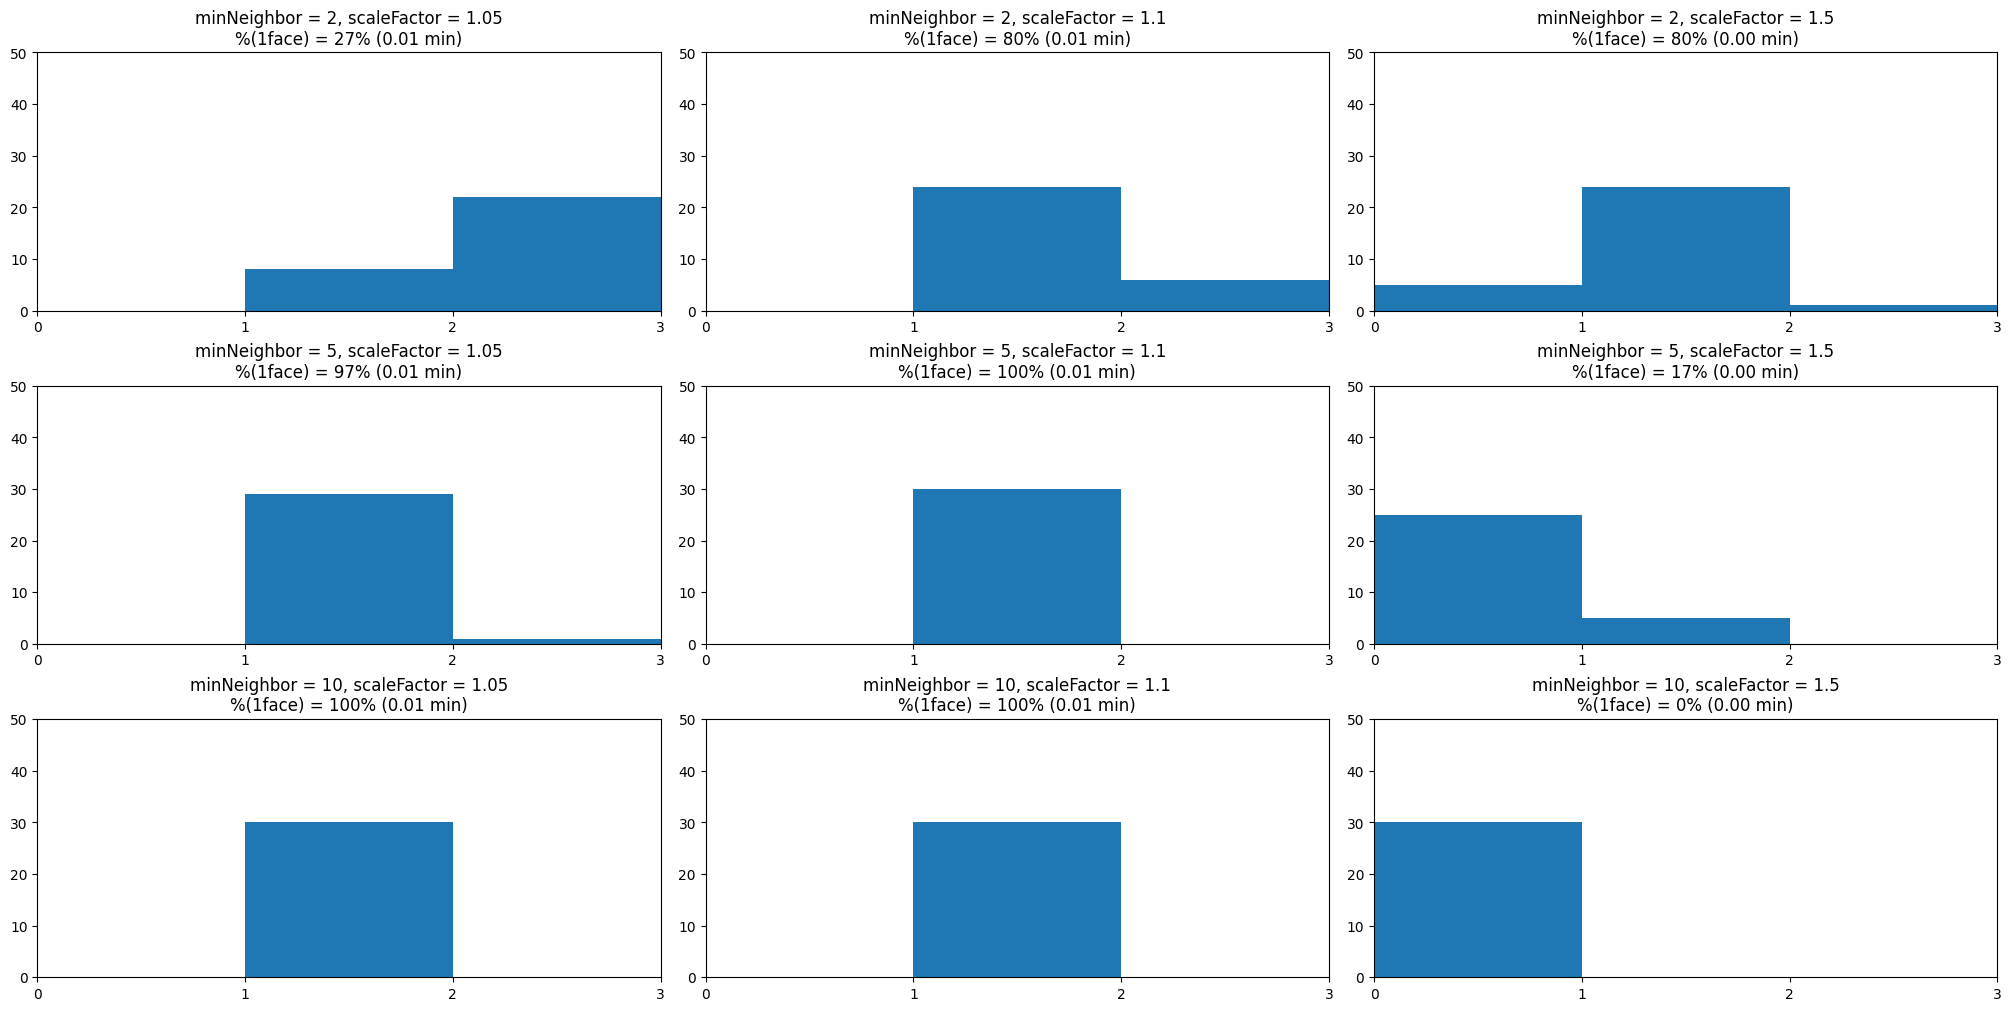

最佳參數：minNeighbors = 5, scaleFactor = 1.1


In [7]:
# best_prop1：記錄偵測到單一人臉比例最高的值，初始值為-1
best_prop1 = -1

# best_para：記錄最佳參數組合(minNeighbors, scaleFactor)，初始值為None
best_para = None

# 建立畫布，設定寬度為20吋、高度為10吋
# 並啟用constrained_layout，自動調整子圖、標題與軸標籤之間的間距，避免重疊
fig = plt.figure(figsize = (20, 10), constrained_layout = True)

# 計數器，用於指定子圖位置
count = 1

# 對每組minNeighbors與scaleFactor的組合進行偵測結果分析
for k in range(len(minNeighbors_list) * len(scaleFactors_list)):
    
    # 將第k組參數對應的偵測結果轉為numpy陣列，方便後續統計
    allfaces = np.array(Nallfaces[k])
    
    # 計算偵測到單一人臉的比例(百分比)，若該組結果為空陣列，則比例設為0
    prop1 = 0 if allfaces.size == 0 else 100 * np.mean(allfaces == 1)
    
    # 取得對應的minNeighbors與scaleFactor參數
    nei, sF = neigh[k], scaleF[k]

    # 如果本組參數偵測到單一人臉的比例高於目前最佳值，則更新最佳比例與對應參數
    if prop1 > best_prop1:
        best_prop1 = prop1
        best_para = (nei, sF)

    # 根據minNeighbors和scaleFactor數量，自動新增子圖，位置由count決定
    ax = fig.add_subplot(len(minNeighbors_list), len(scaleFactors_list), count)

    # 設定y軸範圍為0~50
    ax.set_ylim(0, 50)

    # 設定x軸範圍為0~3
    ax.set_xlim(0, 3)

    # 設定x軸刻度為0、1、2、3
    ax.set_xticks([0, 1, 2, 3])

    # 繪製直方圖，顯示每幀偵測到的人臉數量
    # bins = [0, 1, 2, 3]：將資料分為三個區間
    # 0 ≤ x < 1 → 偵測到0張臉
    # 1 ≤ x < 2 → 偵測到1張臉
    # 2 ≤ x < 3 → 偵測到2張臉
    ax.hist(allfaces, bins = [0, 1, 2, 3])

    # 設定子圖標題，顯示minNeighbors、scaleFactor、單一人臉比例(%)以及運算時間(分鐘)
    ax.set_title(f"minNeighbor = {nei}, scaleFactor = {sF}\n%(1face) = {prop1:.0f}% ({times[k] / 60:.2f} min)")

    # 子圖計數器遞增，用於下一個子圖的位置
    count += 1

# 顯示整個畫布
plt.show()

# 如果已找到最佳參數，則印出minNeighbors與scaleFactor，否則顯示尚未找到最佳參數的訊息
if best_para is not None:
    print(f"最佳參數：minNeighbors = {best_para[0]}, scaleFactor = {best_para[1]}")
else:
    print("尚未找到最佳參數")

In [8]:
# 在影像上畫出指定的矩形框(不填滿)
# objects：包含多個物件框的列表，每個框為[x, y, width, height]
# ax：matplotlib的子圖物件(Axes)，用來繪圖
# color：矩形框的顏色(預設紅色)

def plot_rectangle(objects, ax, color="red"):
    # 依序畫出每個矩形框
    for obj in objects:
        # obj[:2]是左上角座標(x, y)，obj[2], obj[3]是寬度與高度
        # fill = False：只畫邊框、不填滿
        # color = color：使用呼叫者指定的顏色

        ax.add_patch(mpatches.Rectangle(obj[:2], obj[2], obj[3], fill = False, color = color))

# 顯示影像，並標示所有偵測到的物件與對應名稱
# img：輸入的影像資料(通常為numpy陣列格式)
# objects：包含多種物件偵測結果的列表，每類為一組框框([x, y, w, h])
# object_names：對應每類物件的名稱(例如："Face", "Eye", "Profile face")
# ax：matplotlib的子圖物件(Axes)，用來顯示影像與繪圖

def plot_objects(img, objects, object_names, ax):
    # 設定每類物件對應的顏色(紅、藍、黃)
    colors = ["red", "blue", "yellow"]

    # 顯示影像，將像素值標準化至0~1(避免顏色過亮)
    ax.imshow(img / 255.0)

    # 設定第一個物件名稱文字的y座標位置
    count = 100

    # 同時迭代每類物件的框框(obj)、名稱(nm)與對應顏色(color)
    for obj, nm, color in zip(objects, object_names, colors):
        # 在ax子圖上畫出該類物件的所有偵測框，顏色由color指定
        plot_rectangle(obj, ax, color = color)

        # 在影像座標(x = 800, y = count)顯示該物件名稱
        # 800：文字的水平位置(x座標)
        # count：文字的垂直位置(y座標)，初始為100，後續每次下移50，以避免文字重疊
        # nm：要顯示的文字內容(物件名稱)
        # color：文字顏色，與該物件的框框顏色相同
        # fontsize：文字大小(預設20)
        ax.text(800, count, nm, color = color, fontsize = 20)

        # 更新y座標位置，避免下一個文字與前一個重疊
        count += 50

In [9]:
# 指定輸出圖片的資料夾名稱
dir_image = "output_dir/"

# 如果資料夾不存在，則建立資料夾
# exist_ok = True可避免資料夾已存在時發生錯誤
os.makedirs(dir_image, exist_ok = True)

# 物件名稱清單，用於標示偵測結果
obj_names = ["Face", "Eye", "Profile face"]

# 對應的Haar Cascade分類器清單
objects_cascades = [haar_face_cascade, haar_eye_cascade, haar_profile_cascade]

# 對每一幀影像進行偵測與標示
# frames為多幀影像列表，idx為幀索引，img為當前幀影像
for idx, img in enumerate(frames):
    # 儲存每類物件的偵測結果(每類一組框框)
    objs = []

    # 對每個分類器執行偵測，並將結果加入objs
    for cascade in objects_cascades:
        objs.append(get_bounding_box(img, cascade, best_para[0], best_para[1]))

    # 建立圖表，設定大小為10x10吋
    fig = plt.figure(figsize = (10, 10))

    # 建立1x1子圖
    ax = fig.add_subplot(1, 1, 1)

    # 移除x軸刻度
    ax.set_xticks([])

    # 移除y軸刻度
    ax.set_yticks([])

    # 繪製影像與偵測結果(框與名稱)
    plot_objects(img, objs, obj_names, ax)

    # 儲存當前幀為png檔，檔名格式為frame00000.png、frame00001.png ...
    # bbox_inches='tight'去除多餘邊界，pad_inches = 0表示不額外留白
    plt.savefig(os.path.join(dir_image, f"frame{idx:05d}.png"), bbox_inches='tight', pad_inches = 0)

    # 關閉圖表，釋放記憶體
    plt.close('all')

In [10]:
# 取得資料夾中所有以.png結尾的檔案名稱，並以字母順序排序
filenames = sorted([fnm for fnm in os.listdir(dir_image) if fnm.endswith(".png")])

# 使用imageio.get_writer()方法建立GIF寫入器，mode='I'表示多幀模式
with imageio.get_writer(os.path.join(dir_image, '1.gif'), mode='I') as writer:
    # 逐一讀取排序後的每張圖片
    for filename in filenames:
        # 讀取圖片檔案
        image = imageio.imread(os.path.join(dir_image, filename))

        # 將該圖片加入GIF動畫中
        writer.append_data(image)

# 輸出GIF儲存成功的訊息
print("GIF產生完成！")

# 輸出GIF檔案名稱的訊息
print("檔案名稱：1.gif")

# 輸出GIF檔案儲存路徑的訊息
print("1.gif 檔案已儲存到 E:\\Colab第三階段202505\\ch22_20250902\\output_dir 資料夾")

GIF產生完成！
檔案名稱：1.gif
1.gif 檔案已儲存到 E:\Colab第三階段202505\ch22_20250902\output_dir 資料夾
